**Nama : Rizky Wahyudi**
**<p>Email : rizkywhyd10@gmail.com**
<p>Sumber Data : https://www.kaggle.com/shenba/time-series-datasets?select=daily-minimum-temperatures-in-me.csv

In [58]:
#untuk dataframe
import numpy as np
import pandas as pd

#untuk split data
from sklearn.model_selection import train_test_split

# untuk preprocessing dan layer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout

# untuk visualisasi plot
import matplotlib.pyplot as plt

In [59]:
#Memanggil dan menampilkan data
df = pd.read_csv('daily-minimum-temperatures-in-me.csv')
df.head()

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [60]:
#Melihat informasi data (tipe data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        3650 non-null   object
 1   Daily minimum temperatures  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


In [61]:
#Mengubah tipe data string ke float/numerik
df['Daily minimum temperatures'] = pd.to_numeric(df['Daily minimum temperatures'],errors='coerce')

In [62]:
#Mengecek apakah terdapat nilai yang hilang
df.isnull().sum()

Date                          0
Daily minimum temperatures    3
dtype: int64

In [63]:
#Menghapus dan mengecek nilai yang hilang
df.dropna(subset=['Daily minimum temperatures'],inplace=True)
df.isnull().sum()

Date                          0
Daily minimum temperatures    0
dtype: int64

In [64]:
#Melihat informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3647 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        3647 non-null   object 
 1   Daily minimum temperatures  3647 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.5+ KB


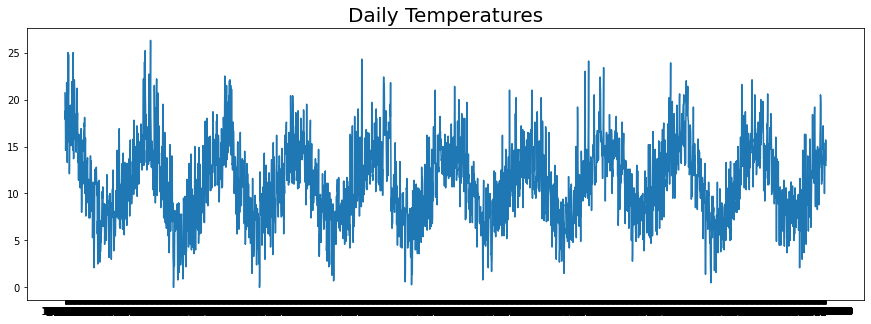

In [65]:
#Membuat plot data time series
dates = df['Date'].values
temperature  = df['Daily minimum temperatures'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, temperature)
plt.title('Daily Temperatures',
          fontsize=20);

In [66]:
#Membagi dataset menjadi 80% data training dan 20% data validation
x_train, x_valid, y_train, y_valid = train_test_split(temperature, dates, train_size=0.8, test_size = 0.2, shuffle = False )

In [67]:
#Menghitung jumlah data train dan validasi
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_valid))

Total Data Train :  2917
Total Data Validation :  730


In [68]:
#Mengembalikan label dan atribut dari dataset dalam bentuk batch
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [69]:
#Membuat model dengan 2 buah layer LSTM dan penerapan Sequential
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=60, batch_size=100, shuffle_buffer=1000)

model = Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])

In [70]:
#Menghitung nilai MAE, 10% skala data
Mae = (df['Daily minimum temperatures'].max() - df['Daily minimum temperatures'].min()) * 10/100
print(Mae)

2.63


In [71]:
#Penggunaan Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<2.63 and logs.get('val_mae')<2.63):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [72]:
#Menggunakan Learning Rate pada Optimizer
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [73]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [74]:
#Training model
history = model.fit(train_set, epochs=100, validation_data = val_set, callbacks=[callbacks])

Epoch 1/100
29/29 [==============================] - 14s 251ms/step - loss: 10.4446 - mae: 10.9440 - val_loss: 10.3694 - val_mae: 10.8690
Epoch 2/100
29/29 [==============================] - 6s 203ms/step - loss: 10.0454 - mae: 10.5445 - val_loss: 9.8508 - val_mae: 10.3502
Epoch 3/100
29/29 [==============================] - 6s 201ms/step - loss: 9.4438 - mae: 9.9424 - val_loss: 9.2045 - val_mae: 9.7024
Epoch 4/100
29/29 [==============================] - 6s 205ms/step - loss: 8.7483 - mae: 9.2471 - val_loss: 8.3983 - val_mae: 8.8945
Epoch 5/100
29/29 [==============================] - 6s 204ms/step - loss: 7.7781 - mae: 8.2748 - val_loss: 7.2122 - val_mae: 7.7094
Epoch 6/100
29/29 [==============================] - 6s 203ms/step - loss: 6.3471 - mae: 6.8399 - val_loss: 5.4891 - val_mae: 5.9779
Epoch 7/100
29/29 [==============================] - 6s 204ms/step - loss: 4.4551 - mae: 4.9350 - val_loss: 3.4919 - val_mae: 3.9575
Epoch 8/100
29/29 [==============================] - 6s 207ms

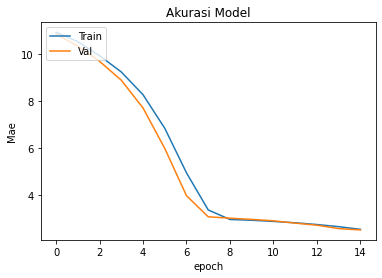

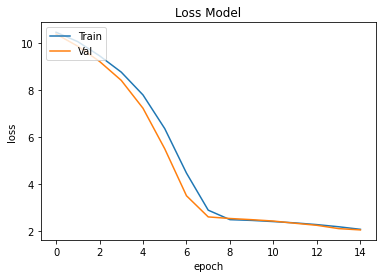

In [75]:
# Plot Accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()